In [1]:
from IPython.display import display, Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#### 基本思想
　　对比基于用户或基于项目的协同过滤方法简单且直观，矩阵分解技术通常更有效率，因为它使我们能够发现用户和项目之间相互作用的潜在因子（特征）。矩阵分解，就是分解一个矩阵。即找出两个或多个矩阵，将它们相乘，返回原始矩阵。从应用角度来看，矩阵分解可用于发现两种不同类型实体之间相互作用的潜在特征。本质采用low-dimensional factor模型，通过几个较少因素的线性组合来拟合用户和项目之间的关系。<br />
　　以MovieLens的数据集为例，纵轴为用户ID，横轴为电影ID。给定每个用户对系统中的某些电影的评分，希望预测用户如何评价还未评分的电影，假设评分为1~5，'-'为没有评分的电影。如下图：

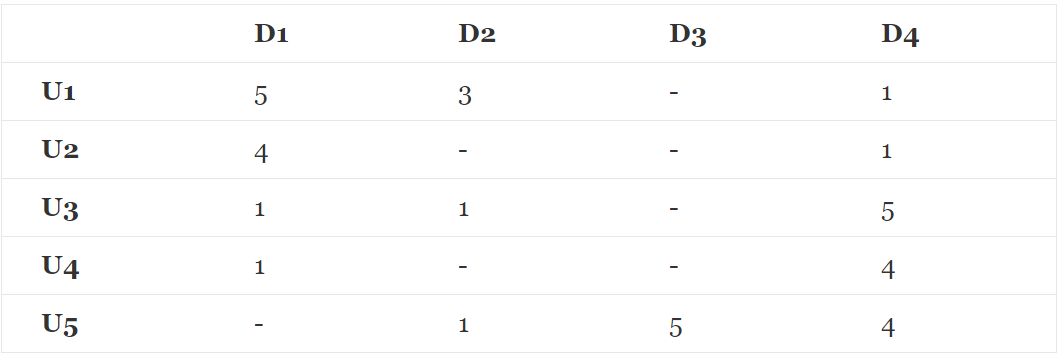

In [2]:
Image('https://raw.githubusercontent.com/martin-1992/\
Recommended-system/master/matrix_factorization/matrix_factorization01.png')

　　现在的目的是预测没有打分的电影，即值为'-'。使用矩阵分解解决该问题的直觉是，有些潜在因子（特征）决定用户如何评价一部电影（比如用户的年龄、性别、职业，电影的演员、导演等）。举个例子，如果两个用户都喜欢这部电影的演员或者如果这部电影是动作电影，则这两个用户将给予这部电影很高的评价，这是两个用户喜欢的类型。因此，如果能发现这些潜在特征，就可以根据用户和电影来预测评分。在尝试发现潜在特征时，假设潜在特征数量小于用户数量和电影数量，因为不可能每个用户都有一个唯一的潜在特征。如果存在这种情况，则预测评分就毫无意义。因为用户不会对其它用户的评分感兴趣。

#### 矩阵分解的数学推导
　　假设有 U 名用户和 D 部电影，$\text {R}$表示用户给电影评分的矩阵，大小为 |U| x |D|。接着，假设有$\text {K}$个潜在特征，找到两个矩阵 $\text {P}$（大小为|U| x K的矩阵）和$\text {Q}$ （大小为|D| x K的矩阵），使这两个矩阵的内积近似原矩阵 $\text {R}$：
$$\text {R}\approx \text {P} \times \text {Q}^{T}=\widehat{\text {R}}$$

　　这样，矩阵$\text {P}$的每一行表示用户和潜在特征的关联强度。类似的，矩阵$\text {Q}$的每一行表示电影和潜在特征的关联强度。为了预测每一位用户$u_{i}$对每一部电影$d_{j}$的评分，需要计算两个向量$u_{i}$和$d_{j}$的内积：
$$\widehat{r}_{ij} = p_{i}^{T}q_{j}=\sum_{k=1}^{k}p_{ik}q_{kj}$$

　　现在，是如何找到矩阵$\text {P}$和矩阵$\text {Q}$。一种方法是初始化两个矩阵，填充随机值，计算这两个矩阵的内积和原矩阵的误差，使用梯度下降，逐步迭代减少误差，找到局部的最小值。估计值和真实评分的误差，通常使用平方误差公式：
$$e_{ij}^{2}=(r_{ij}-\widehat{r}_{ij})^{2}=(r_{ij}-\sum_{k=1}^{K}p_{ik}q_{kj})^{2}$$

为了最小化误差，需要知道当前值的梯度，因此对误差等式求梯度：
$$\frac{\partial e_{ij}^{2}}{\partial p_{ik}} = -2(r_{ij}-\widehat{r_{ij}})(q_{kj})=-2e_{ij}q_{kj}\\
\frac{\partial e_{ij}^{2}}{\partial q_{ik}} = -2(r_{ij}-\widehat{r_{ij}})(p_{ik})=-2e_{ij}p_{ik}$$

参数更新等式：
$$p_{ik}'=p_{ik}-\alpha \frac{\partial e_{ij}^{2}}{\partial p_{ik}} =p_{ik}+2 \alpha e_{ij}q_{kj}\\
q_{kj}'=q_{kj}-\alpha \frac{\partial e_{ij}^{2}}{\partial q_{kj}} =q_{kj}+2 \alpha e_{ij}p_{ik}$$

　　这里，$\alpha$是学习速率，控制梯度下降时所走的步长大小，通常为0.0002。注意，我们并不是真的要将矩阵$\text {P}$和$\text {Q}$的内积近似$\text {R}$。而是，尽量将已评分的用户项目对的误差最小化。换句话说，设$\text {T}$为一组元组，元组里每个元素形式为$(u_{i}, d_{j}, r_{ij})$，这样$\text {T}$包含所有已评分的用户-项目对，仅对$(u_{i}, d_{j}, r_{ij})$这些进行最小化误差（$\text {T}$是训练集），剩下的未评分，由用户、电影和学习到的潜在特征决定。<br />
　　使用以上更新等式，迭代更新直到误差收敛到最小值。使用以下等式计算总体误差，决定何时停止：
$$\text {E}=\sum_{(u_{i}, d_{j}, r_{ij})\in T} e_{ij}=\sum_{(u_{i}, d_{j}, r_{ij})\in T} (r_{ij}-\sum_{k=1}^{K}p_{ik}q_{kj})^{2}$$

#### 正则化
　　以上算法是分解矩阵的基本算法，对该算法加上正则化可以避免过拟合。通过添加 $\beta $和修改平方差公式：
$$e_{ij}^{2}=(r_{ij}-\sum_{k=1}^{K}p_{ik}q_{kj})^{2}+\frac{\beta }{2}\sum_{k=1}^{K}(\left \| \text {P} \right \|^{2} + \left \| \text {Q} \right \|^{2}) $$

　　新参数 $\beta $ 用于控制用户特征向量 $\text {P}$和电影特征向量 $\text {Q}$的大小，让其内积近似 $\text {R}$而不必包含大量数字。实际上，$\beta $通常设置为0.02。对新的平方差等式求导，得出新的参数更新等式：
$$p_{ik}'=p_{ik}-\alpha \frac{\partial e_{ij}^{2}}{\partial p_{ik}} =p_{ik}+\alpha (2e_{ij}q_{kj} - \beta p_{ik})\\
q_{kj}'=q_{kj}-\alpha \frac{\partial e_{ij}^{2}}{\partial q_{kj}} =q_{kj}+\alpha (2e_{ij}q_{ik} - \beta q_{kj})$$

### als_mf算法流程：
- 初始化矩阵U和M，U矩阵大小为user_id * n_feature，其中user_id为用户id数，n_fearure为潜在特征；同理M矩阵大小为item_id * n_feature，其中item_id为项目id数；
- 生成user_id - item_id矩阵，其中行为user_id，列为item_id，值为用户评分rating，减去全局评分的均值；
- 误差公式为：$\sum_{(i, j) \in I}(r_{ij}-u_{i}^{T}m_{j})^{2}$，为了防止过拟合，加上正则项，惩罚过大参数：$$f(U, M) =\sum_{(i, j) \in I}(r_{ij}-u_{i}^{T}m_{j})^{2} + \lambda (\sum_{i} \eta _{ui} \left \| \text {u}_{i} \right \|^{2}) + \lambda (\sum_{i} \eta _{mj} \left \| \text {m}_{j} \right \|^{2}) $$ 其中$n_{ui}$为第i位用户的评分数，同理$n_{mj}$为第j个项目的评分数；
- 固定M矩阵，使用梯度下降，对f(U, M)求梯度$\frac{\partial f}{\partial  u_{ki}} = 0$，即：
$$\frac{\partial (\sum_{(i, j) \in I}(r_{ij} - \mathbf {u_{i}^{T}m_{j}})^{2} + \lambda (\sum_{i} \eta _{ui} \left \| \text {u}_{i} \right \|^{2}) + \lambda (\sum_{i} \eta _{mj} \left \| \text {m}_{j} \right \|^{2}))}{\partial u_{ki}} = 0\\
-2\sum_{j \in I_{i}}(r_{ij} - \mathbf {u_{i}^{T}m_{j}})m_{kj} + 2 \lambda \eta _{ui} \text {u}_{ki} = 0\\
\sum_{j \in I_{i}}(\mathbf {u_{i}^{T}m_{j}} - r_{ij})m_{kj} + \lambda \eta _{ui} \text {u}_{ki} = 0\\
\sum_{j \in I_{i}} m_{kj} \mathbf {m_{j}^{T}u_{i}} - \sum_{j \in I_{i}} m_{kj} r_{ij}  + \lambda \eta _{ui} \text {u}_{ki} = 0\\
\sum_{j \in I_{i}} m_{kj} \mathbf {m_{j}^{T}u_{i}} + \lambda \eta _{ui} \text {u}_{ki} = \sum_{j \in I_{i}} m_{kj} r_{ij}\\
(M_{I_{i}} M_{I_{i}}^{T} + \lambda \eta _{ui} E) \mathbf {\text {u}_{i}}= M_{I_{i}} R_{(i, I_{i})}^{T}\\
\mathbf {\text {u}_{i}} = A_{i}^{-1} V_{i}$$ 其中$A_{i} = M_{I_{i}} M_{I_{i}}^{T} + \lambda \eta _{ui} E$，$M_{I_{i}}$为已评分的项目ID，$\eta _{ui}$为总共的已评分项目ID数，$V_{i} = M_{I_{i}} R_{(i, I_{i})}^{T}$，E为$n_{f}*n_{f}$的单位矩阵，f为潜在特征数；
- 同样固定U矩阵，使用梯度下降，对f(U, M)求梯度$\frac{\partial f}{\partial  m_{kj}} = 0$，即：$\mathbf {\text {m}_{j}} = A_{j}^{-1} V_{j}$，其中$A_{j} = U_{I_{j}} M_{I_{j}}^{T} + \lambda \eta _{mj} E$；
- 预测值为$\widehat{r}_{ij}= \mathbf {u_{i}^{T}m_{j}}$，不断迭代上面两步，直到最近两次误差收敛到一个阈值时，停止更新参数。

注意的是，进行参数更新的已评分的item_id和user_id的实例，即拟合已评分的user-item矩阵，然后去预测未评分的user-item的评分。

### pmf算法讲解：
　　假设有M部电影，N名用户，评分值范围为1到K。设$R_{ij}$表示第i名用户对第j部电影的评分，$U\in R^{D\times N}$为潜在用户特征矩阵，$V\in R^{D\times M}$为潜在电影特征矩阵，其列向量$U_{i}$和$V_{j}$分别表示用户特定和电影特定的潜在特征向量。用贝叶斯的观点来说，$R$是观测到的值，而$U$和$V$描述了系统的内部特征，是需要估计的。由于模型表现是通过计算测试集上的均方根误差（RMSE）来衡量的，首先定义观测噪声（观测评分矩阵$R$和预测评分矩阵$\widehat{R}$之差）为高斯分布的概率模型，其条件分布为：
$$p(R|U, V, \sigma ^{2})=\prod_{i=1}^{N} \prod_{j=1}^{M}[N(R_{ij}|U_{i}^{T} V_{j}, \sigma ^{2})]^{I}_{ij}$$
　　其中$N(x|\mu , \sigma ^{2})$是均值为$\mu$，方差为$\sigma ^{2}$的高斯分布的概率密度函数，$I_{ij}$是指示函数，如果用户 i 评分过电影 j 为1，否则为0。用户和电影特征向量为零均值的高斯先验分布：
$$p(U | \sigma _{U}^{2})=\prod_{i=1}^{N} N(U_{i} | 0, \sigma _{U}^{2} \mathbf{I}), \ \ \ p(V | \sigma _{V}^{2})=\prod_{j=1}^{M} N(V_{j} | 0, \sigma _{V}^{2} \mathbf{I})$$

　　综合以上两个概率密度函数，利用后验概率推导，可得：
$$p(U, V | R) = p(U, V, R) / p(R) \propto p(U, V, R) = p(R| U, V)p(U)p(V)$$
　　在取对数：
$$\ln p(U, V | R) = \ln p(R| U, V) + \ln p(U) + \ln p(V)$$

　　于是用户和电影特征的后验分布记录为：
$$\ln p(U, V | R, \sigma ^{2}, \sigma _{V}^{2}, \sigma _{U}^{2})=- \frac{1}{2\sigma ^{2}} \sum_{i=1}^{N} \sum_{j=1}^{M} I_{ij} (R_{ij}-U_{i}^{T}V_{j})^{2} - \frac{1}{2\sigma _{U}^{2}}\sum_{i=1}^{N} U_{i}^{T}U_{i} - \frac{1}{2\sigma _{V}^{2}}\sum_{j=1}^{M}V_{j}^{T}V_{j} - \frac{1}{2}((\sum_{i=1}^{N} \sum_{j=1}^{M} I_{ij}) \ln \sigma ^{2} + ND \ln \sigma _{U}^{2} +MD \ln _{\sigma }^{2}) + C$$
　　其中C是常数不依赖参数，最大化上式等于使用二次正则化项来最小化平方和误差目标函数：
$$E(U, V)=\frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{M} I_{ij} (R_{ij}-U_{i}^{T}V_{j})^{2} + \frac{\lambda _{U}}{2} \sum_{i=1}^{N} \left \| U_{i} \right \|_{Fro}^{2} + \frac{\lambda _{V}}{2} \sum_{j=1}^{M} \left \| V_{j} \right \|_{Fro}^{2}$$
　　$\lambda _{U}=\frac{\sigma ^{2}}{\sigma _{U}^{2}}, \ \ \lambda _{V}=\frac{\sigma ^{2}}{\sigma _{V}^{2}}, \ \ \left \| \cdot  \right \|_{Fro}^{2}$表示Frobenius Norm。上式给出的目标函数的局部最小值可以通过在U和V中执行梯度下降来找到。$R_{ij}$是标量，$U_{i}, V_{j}$都是维度为D的向量，后两项相当于约束了内部特征矩阵$U, V$的范数。标记$I_{ij}$表示用户 i 是否对电影 j 评分。

　　接着固定Ｍ矩阵，使用梯度下降，对E(U, V)求梯度$\frac{\partial E}{\partial  u_{ki}} = 0$ ，即：
$$\sum_{i=1}^{N} \sum_{j=1}^{M} I_{ij} (R_{ij}-U_{i}^{T}V_{j})U_{i} + \lambda _{U} \sum_{i=1}^{N} U_{i}$$
　　同样固定Ｕ矩阵，使用梯度下降，对E(U, V)求梯度$\frac{\partial E}{\partial  m_{kj}} = 0$ ，即：
$$\sum_{i=1}^{N} \sum_{j=1}^{M} I_{ij} (R_{ij}-U_{i}^{T}V_{j})V_{j} + \lambda _{V} \sum_{i=1}^{N} V_{j}$$

　　如果需要限制评分范围，可对用户特征向量和电影特征向量之间的内积加上logisitc函数$g(x)=1 / (1+exp(-x)$，最终的能量函数为,，在求梯度下降：
$$E(U, V)=\frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{M} I_{ij} (R_{ij}-g(U_{i}^{T}V_{j}))^{2} + \frac{\lambda _{U}}{2} \sum_{i=1}^{N} \left \| U_{i} \right \|_{Fro}^{2} + \frac{\lambda _{V}}{2} \sum_{j=1}^{M} \left \| V_{j} \right \|_{Fro}^{2}$$